# 1. Brief Introduction of SCWT

The **Stroop Color and Word Test (SCWT)**, created by John Ridley Stroop in the 1930s, is a psychological assessment tool used to measure an individual's selective attention capacity and skills, as well as their processing speed. In this test, participants are presented with **a list of words**, with each word displayed in **a color of ink different from the color that the word denotes**. For instance, the word **"blue"** might be printed **in red ink**.

There are typically two conditions in this test: a **congruent** condition where the word and its color **match**, and an **incongruent** condition where the word and its color **do not match**. Participants are asked to **name the ink color**, **ignoring the written word**, which creates a **cognitive conflict**, as reading words is a much more automatic process than naming colors.

The **Stroop effect**, which is the **delay in reaction times** in the **incongruent** condition compared to the congruent condition, demonstrates the nature of **automatic processing** and how it can interfere with other cognitive processes. It has been widely used in various psychological research to understand cognitive processing and even to diagnose various neurological and psychiatric conditions, as individuals with these conditions might exhibit different reaction times compared to healthy controls.

Additionally, it is used to explore the neural mechanisms underlying cognitive control and has revealed insights into how the brain handles **conflicting information**. The test is leveraged in various settings including clinical, cognitive psychology, and neuroscience research settings, proving to be a cornerstone in cognitive psychology due to its simplicity and efficacy in probing cognitive control and processing speed. It remains a **widely used tool** nearly a century after its development, speaking to its foundational role in the psychology field.

## 1.1 Experiment Design
The experiment unfolded as follows: each trial began with a 0.5-second inter-trial interval (ITI), followed by the presentation of a word, and then a pause to await a response. Participants were instructed to disregard the word's meaning and instead concentrate on its color. After 24 practice trials with feedback, participants were required to complete 120 trials to conclude the experiment.

<p style="text-align:center;"> 
<img src="Pictures/Stroop_Procedure.png" alt="Mental Rotation Procedure" width="960" />
</p>

## 1.2 Work Flow
In the current Jupyter notebook, we began by merging the individual data files for each subject. We then implemented basic quality control by ensuring the correctness rate exceeded a specified threshold. Following this, we calculated the reaction times and error rates for each subject at various angles. Lastly, we visually represented this data through graphs and conducted statistical analysis to test our hypothesis. 

**Note**: Citation was attached in the last section of this notebook.

In [1]:
# Imports
from pathlib import Path
## Data, plot and statistical model
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
## Pingouin add function for pd.DataFrame
## e.g. df.rm_anova performs repeated measurement anova for df
import pingouin as pg
## Suppress future warnings
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = '10'
plt.style.use('seaborn-v0_8-pastel')

# 2. Data Preparation
Within the "Data" folder, various subfolders house data collected from different platforms. This data was consolidated into a single dataframe object. Subsequently, we tallied the number of subjects contributing data from each platform.

In [2]:
from_folder = Path('Data/Stroop')
# Combine subject data to a dataframe and then add their group and id
data = []
for file in from_folder.rglob('*.csv'):
    datum = pd.read_csv(file)
    datum['sub_id'] = file.stem
    datum['group'] = file.parent.stem.split('_')[0]
    data.append(datum)
data = pd.concat(data)

# Create a {sub_id: group} mapping
mapping = data.drop_duplicates('sub_id').set_index('sub_id')['group'].to_dict()
# The number of each group
raw_subject_n = data.drop_duplicates(subset=['sub_id']).groupby('group')['sub_id'].count()
raw_subject_n.name = 'raw count'
print('The following illustrates the number of participants from each group:')
raw_subject_n

The following illustrates the number of participants from each group:


group
Naodao      41
Offline     37
Pavlovia    44
Name: raw count, dtype: int64

## 2.1 Brief Explanation of Data Columns
Each row represents a trial undertaken by a specific subject. The columns are defined as follows:
- **trial_type**: *trial type*. either congruent or incongruent
- **corr**: *correctness*. Indicates whether the response in the current trial was correct, denoted as 1, or incorrect, denoted as 0.
- **rt**: *response time*. The time, in seconds, taken by the subject to respond.
- **sub_id**: *subject ID*. The unique identifier for the subject participating in the trial.
- **group**: Represents the platform where the subjects participated in the experiment. The possible values are:
  - Naodao: Referring to the [Naodao Research Platform](https://www.naodao.com).
  - Pavlovia: Referring to the [Pavlovia platform](https://pavlovia.org).
  - Offline: Denoting subjects recruited at the offline lab at Beijing Normal University.


In [3]:
data

,rt,corr,trial_type,sub_id,group
0,0.6991,1.0,congruent,001,Naodao
1,0.8347,1.0,incongruent,001,Naodao
2,0.6335,1.0,congruent,001,Naodao
3,0.6169,1.0,congruent,001,Naodao
4,0.7015,1.0,congruent,001,Naodao
...,...,...,...,...,...
115,0.5676,1.0,incongruent,122,Pavlovia
116,0.6503,1.0,congruent,122,Pavlovia
117,1.1832,1.0,incongruent,122,Pavlovia
118,0.6346,1.0,congruent,122,Pavlovia


# 3. Quality Control
We conducted basic quality control on the data, excluding subjects with a **correctness rate below 75%**. No subjects were removed from any of the groups.

In [4]:
corr_rate = data.groupby(['sub_id'])['corr'].mean()
corr_rate.name = 'corr_rate'
data = (data
        .merge(corr_rate.reset_index(), on='sub_id')
        .query('corr_rate >= 0.80')
        .drop(columns=['corr_rate']))
clean_subject_n = data.drop_duplicates(subset=['sub_id']).groupby('group')['sub_id'].count()
clean_subject_n = pd.DataFrame(clean_subject_n)
clean_subject_n.columns = ['after clean']
clean_subject_n['before clean'] = raw_subject_n
print('The following illustrates the number of participants from each group:')
clean_subject_n

The following illustrates the number of participants from each group:


,after clean,before clean
group,,
Naodao,41,41
Offline,37,37
Pavlovia,44,44


# 4. Measurement Calculation

As previously mentioned, the SCWT concentrates on evaluating the **response time** in congruent and incongruent trials. In the forthcoming phase of our analysis, we will calculate the **mean reaction time** of subjects during various trial types.

In [5]:
# Error rate
plot_data = data.groupby(['sub_id', 'trial_type'])['rt'].mean()
plot_data.name = 'MnRT'
plot_data = plot_data.reset_index()
plot_data['group'] = plot_data['sub_id'].map(mapping)
plot_data.to_csv('Data/Stroop.csv', index=False)

## 4.1 Brief Explanation of Data Columns
In addition to the variables introduced in section 2.1, we have incorporated the following:
- **MnRT**: *mean response time*. 

In [6]:
plot_data

,sub_id,trial_type,MnRT,group
0,001,congruent,0.659853,Naodao
1,001,incongruent,0.747927,Naodao
2,002,congruent,0.632215,Naodao
3,002,incongruent,0.769838,Naodao
4,003,congruent,0.719822,Naodao
...,...,...,...,...
239,120,incongruent,1.035197,Pavlovia
240,121,congruent,0.726378,Pavlovia
241,121,incongruent,0.769725,Pavlovia
242,122,congruent,0.622220,Pavlovia


# 4. Plots
Visualizations can enhance the comprehension of the results. These images can be found in the "Pictures" folder.

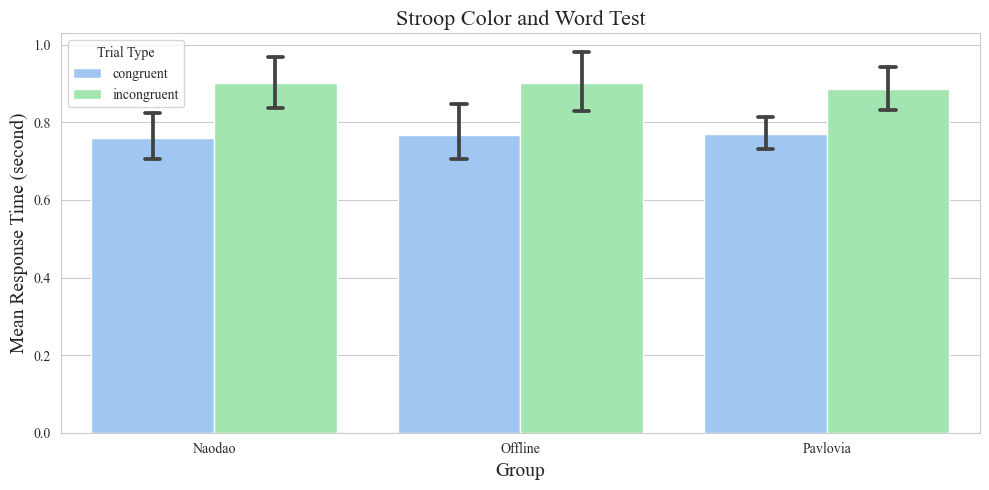

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=plot_data, x='group', y='MnRT', hue='trial_type', capsize=0.05, ax=ax)
ax.set_ylabel('Mean Response Time (second)', fontsize=14)
ax.set_xlabel('Group', fontsize=14)
ax.set_title('Stroop Color and Word Test')
ax.title.set_size(16)
ax.legend().set_title('Trial Type')
plt.tight_layout()
fig.savefig('Pictures/Stroop_Result.png')

# 5. Statistical Analysis
As mentioned earlier, the typical **Stroop effect** involves a **longer response time** when responding to **incongruent trials** compared to responding to congruent ones.

## 5.1 Effect Replication
Initially, we sought to confirm the recurrence of the classical effect within each group. We employed a repeated measures ANOVA (RM-ANOVA) to accomplish this. Interpretation of each column in the data set as detailed below:

- **ddof1**: Degrees of freedom (numerator)
- **ddof2**: Degrees of freedom (denominator)
- **F**: F-value
- **p-unc**: Uncorrected p-value
- **np2**: Partial eta-square effect size
- **ng2**: Generalized eta-square effect size

These definitions are derived from the documentation of the Pingouin Python package, further details of which can be found at [pg.rm_anova](https://pingouin-stats.org/build/html/generated/pingouin.rm_anova.html#pingouin.rm_anova).

We conducted paired t-tests within each of the three groups to assess the Stroop effect. In all three groups, we found a **significant Stroop effect** (*p*s < 0.001), with similar **effect sizes (Cohen's d) of approximately** [0.57, 0.69]. 

In [8]:
result_list = []

for group in plot_data['group'].unique():
    this_data = plot_data.query(f'group == "{group}"')
    # Perform ANOVA analysis and the select columns (for simplicity)
    result = pg.ttest(
        x=this_data.query('trial_type == "incongruent"')['MnRT'],
        y=this_data.query('trial_type == "congruent"')['MnRT'],
        paired=True, alternative='greater').round(5)
    result = result[['T', 'dof', 'p-val', 'cohen-d', 'BF10']]
    result.insert(0, 'group', group)
    result_list.append(result)
pd.concat(result_list)

,group,T,dof,p-val,cohen-d,BF10
T-test,Naodao,9.24743,40,0.0,0.68960,1.069e+09
T-test,Offline,8.81998,36,0.0,0.56611,1.305e+08
T-test,Pavlovia,9.45157,43,0.0,0.68957,3.815e+09


## 5.2 Comparison Between Groups
Next, we aim to identify any significant disparities between the different groups by utilizing mixed ANOVA. In this approach, the **trial type** served as the **within-subject** independent variable, while the **group** designation functioned as the **between-subject** independent variable.

The outcomes indicate that **neither a main effect** of group **nor an interaction** effect between group and angle is present (*p*s > .36). Even if such effects were discernible, they would be considered minor, registering **effect sizes** within the range of **0.0002 to 0.0008**, according to Cohen's 1998 classification of effect sizes (Cohen, 2013).

In [9]:
result = plot_data.mixed_anova(
    dv='MnRT', subject='sub_id', within='trial_type', between='group', effsize='ng2'
).round(5)
result[['Source', 'DF1', 'DF2', 'F', 'p-unc', 'ng2']]

,Source,DF1,DF2,F,p-unc,ng2
0,group,2,119,0.01264,0.98744,0.00020
1,trial_type,1,119,251.14269,0.00000,0.09495
2,Interaction,2,119,1.02435,0.36217,0.00086


# References 
- Cohen, J. (2013). Statistical power analysis for the behavioral sciences. Academic press.
- Hedge, C., Powell, G., & Sumner, P. (2018). The reliability paradox: Why robust cognitive tasks do not produce reliable individual differences. Behavior research methods, 50, 1166-1186.